# Tensorflow Eager mode

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

assert tf.__version__ == '2.0.0-alpha0'

## Eager Enabled (Default)

In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2., 2.],
     [1., 0.]]

m = tf.matmul(x, x)

m

<tf.Tensor: id=2, shape=(2, 2), dtype=float32, numpy=
array([[6., 4.],
       [2., 2.]], dtype=float32)>

In [4]:
m.numpy()

array([[6., 4.],
       [2., 2.]], dtype=float32)

## Generate fake data

In [5]:
X, y = make_moons(n_samples=1000,
                  noise=0.1,
                  shuffle=True,
                  random_state=0,
              )

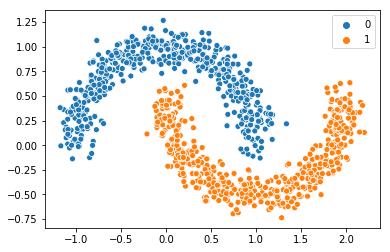

In [6]:
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

## Model (Sequential)

In [7]:
model = Sequential([
    Dense(8, input_shape=(2,), activation='tanh'),
    Dense(2, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model is a Function

In [8]:
model(X[:10])

<tf.Tensor: id=263, shape=(10, 1), dtype=float32, numpy=
array([[0.51483685],
       [0.5164637 ],
       [0.4925993 ],
       [0.49776262],
       [0.508323  ],
       [0.5150215 ],
       [0.50912887],
       [0.4966148 ],
       [0.4887817 ],
       [0.5116496 ]], dtype=float32)>

## Model (Functional)

In [9]:
ins = Input(shape=(2, ))
x1 = Dense(16, activation='tanh')(ins)
x2 = Dense(8, activation='tanh')(x1)
x3 = Dense(2, activation='tanh')(x2)
outs = Dense(1, activation='sigmoid')(x3)

model1 = Model(inputs=ins, outputs=outs)
model2 = Model(inputs=ins, outputs=x3)


model1.compile(optimizer=Adam(lr=0.005),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [10]:
model1.fit(X, y, epochs=30);

Epoch 1/30
1000/1000 [==============================] - 0s 179us/sample - loss: 0.3595 - accuracy: 0.8420
Epoch 2/30
1000/1000 [==============================] - 0s 40us/sample - loss: 0.2857 - accuracy: 0.8770
Epoch 3/30
1000/1000 [==============================] - 0s 43us/sample - loss: 0.2821 - accuracy: 0.8800
Epoch 4/30
1000/1000 [==============================] - 0s 33us/sample - loss: 0.2777 - accuracy: 0.8800
Epoch 5/30
1000/1000 [==============================] - 0s 32us/sample - loss: 0.2721 - accuracy: 0.8840
Epoch 6/30
1000/1000 [==============================] - 0s 36us/sample - loss: 0.2656 - accuracy: 0.8840
Epoch 7/30
1000/1000 [==============================] - 0s 34us/sample - loss: 0.2497 - accuracy: 0.8910
Epoch 8/30
1000/1000 [==============================] - 0s 34us/sample - loss: 0.2200 - accuracy: 0.9070
Epoch 9/30
1000/1000 [==============================] - 0s 35us/sample - loss: 0.1690 - accuracy: 0.9410
Epoch 10/30
1000/1000 [==============================]

In [11]:
model1(X[:10])

<tf.Tensor: id=9050, shape=(10, 1), dtype=float32, numpy=
array([[0.99705327],
       [0.997439  ],
       [0.02942064],
       [0.99589384],
       [0.9990896 ],
       [0.99681574],
       [0.001454  ],
       [0.00526679],
       [0.00372294],
       [0.9990833 ]], dtype=float32)>

In [12]:
X_inner = model2(X)

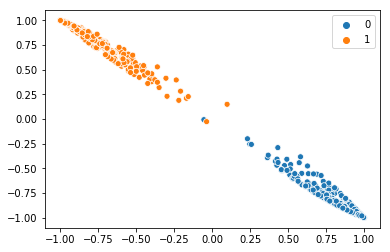

In [13]:
sns.scatterplot(x=X_inner[:,0], y=X_inner[:,1], hue=y);

## Model (Class + manual loss)

In [14]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense_1 = Dense(16, activation='tanh')
        self.dense_2 = Dense(8, activation='tanh')
        self.dense_3 = Dense(2)
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.dense_3(x)

model3 = MyModel()

In [15]:
model3(X[:10])

<tf.Tensor: id=9161, shape=(10, 2), dtype=float64, numpy=
array([[-0.37542742, -0.10537161],
       [-0.42329868, -0.26963205],
       [ 0.32854915,  0.3477606 ],
       [ 0.09642226,  0.09801881],
       [-0.29254758, -0.24075701],
       [-0.37889028, -0.13207647],
       [-0.22483974,  0.01054429],
       [ 0.26699652,  0.37829241],
       [ 0.41345014,  0.38309009],
       [-0.38829794, -0.32040968]])>

## Optimizer and Loss

In [16]:
optimizer = Adam(lr=0.01)
loss = SparseCategoricalCrossentropy(from_logits=True)

In [17]:
logits = model3(X)

In [18]:
loss(y, logits).numpy()

0.6888312697410583

## Gradients

In [19]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        logits = model(inputs)
        loss_value = loss(targets, logits)
    return tape.gradient(loss_value, model.variables)

grad(model3, X, y)

[<tf.Tensor: id=9300, shape=(2, 16), dtype=float64, numpy=
 array([[-0.02394871,  0.04306322, -0.19667428, -0.0012614 , -0.05139807,
          0.03388875, -0.08276819, -0.12074447, -0.0266796 , -0.04856748,
          0.05026003,  0.04627982,  0.05917609,  0.06149771,  0.02185271,
          0.1123165 ],
        [ 0.02383882, -0.03658204,  0.17781049,  0.00273561,  0.02350017,
         -0.02215821,  0.12360236,  0.10897264,  0.02830338,  0.04896267,
         -0.05869644, -0.02578464, -0.03674338, -0.08786005, -0.05239198,
         -0.10115177]])>,
 <tf.Tensor: id=9298, shape=(16,), dtype=float64, numpy=
 array([ 0.00207659,  0.00054069,  0.01214016,  0.00146502, -0.0126548 ,
         0.0056127 ,  0.03214626,  0.00405   ,  0.00256404,  0.00573843,
        -0.00853302,  0.00780505,  0.0071342 , -0.02102339, -0.0221277 ,
        -0.00278556])>,
 <tf.Tensor: id=9296, shape=(16, 8), dtype=float64, numpy=
 array([[ 3.61515711e-02, -1.12859910e-01,  1.58327416e-01,
         -4.18564745e-02, -1.

## Dataset

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(len(X)*2).repeat().batch(32)

## Training Loop

In [21]:
loss_history = []
accuracy_history = []
acc = tf.keras.metrics.SparseCategoricalAccuracy()

for (i, (data, labels)) in enumerate(dataset.take(1000)):
    with tf.GradientTape() as tape:
        logits = model3(data)
        loss_value = loss(labels, logits)

    loss_history.append(loss_value.numpy())
    
    grads = tape.gradient(loss_value, model3.trainable_variables)
    
    optimizer.apply_gradients(zip(grads, model3.trainable_variables))
        
    acc.update_state(labels, logits)
    accuracy = acc.result().numpy()
    accuracy_history.append(accuracy)
    
    if i % 100 == 0:
        print("Iteration: {}, Loss: {:0.3}, Acc: {:0.3}".format(i, loss_value.numpy(), accuracy))

Iteration: 0, Loss: 0.683, Acc: 0.75
Iteration: 100, Loss: 0.241, Acc: 0.864
Iteration: 200, Loss: 0.0638, Acc: 0.888
Iteration: 300, Loss: 0.011, Acc: 0.921
Iteration: 400, Loss: 0.00464, Acc: 0.94
Iteration: 500, Loss: 0.00819, Acc: 0.951
Iteration: 600, Loss: 0.01, Acc: 0.959
Iteration: 700, Loss: 0.00406, Acc: 0.964
Iteration: 800, Loss: 0.00284, Acc: 0.968
Iteration: 900, Loss: 0.0166, Acc: 0.972


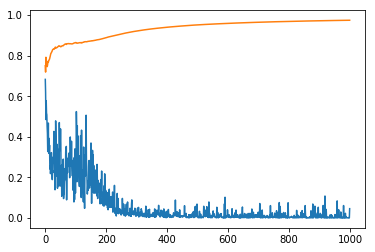

In [22]:
plt.plot(loss_history)
plt.plot(accuracy_history)

## Flow Control

In [23]:
def fizzbuzz(max_num):
    for i in tf.range(max_num):
        if tf.equal(i % 3, 0):
            print('Fizz')
        elif tf.equal(i % 5, 0):
            print('Buzz')
        else:
            print(i.numpy())

fizzbuzz(15)

Fizz
1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14


## Tensorflow Function

In [24]:
@tf.function
def square_if_positive(x):
    if x > 0:
        x = x * x
    else:
        x = 0
    return x

In [25]:
print('square_if_positive(2) = {}'.format(square_if_positive(tf.constant(2))))
print('square_if_positive(-2) = {}'.format(square_if_positive(tf.constant(-2))))

square_if_positive(2) = 4
square_if_positive(-2) = 0


## Disable Eager Mode

In [35]:
tf.compat.v1.disable_eager_execution()

In [27]:
tf.executing_eagerly()

True

In [28]:
x = [[2., 2.],
     [1., 0.]]

m = tf.matmul(x, x)

m

<tf.Tensor: id=199725, shape=(2, 2), dtype=float32, numpy=
array([[6., 4.],
       [2., 2.]], dtype=float32)>

In [29]:
model(X)

<tf.Tensor: id=199743, shape=(1000, 1), dtype=float32, numpy=
array([[0.51483685],
       [0.5164637 ],
       [0.4925993 ],
       [0.49776262],
       [0.508323  ],
       [0.5150215 ],
       [0.50912887],
       [0.4966148 ],
       [0.4887817 ],
       [0.5116496 ],
       [0.4873054 ],
       [0.4999432 ],
       [0.5172881 ],
       [0.4974803 ],
       [0.50122315],
       [0.5083742 ],
       [0.5159197 ],
       [0.503021  ],
       [0.5107541 ],
       [0.506887  ],
       [0.5083351 ],
       [0.488159  ],
       [0.488958  ],
       [0.49036324],
       [0.5169168 ],
       [0.5163709 ],
       [0.51142836],
       [0.50796616],
       [0.5141341 ],
       [0.51007986],
       [0.51716554],
       [0.5121217 ],
       [0.5022807 ],
       [0.5168379 ],
       [0.4873152 ],
       [0.51323336],
       [0.5151279 ],
       [0.48766896],
       [0.5158558 ],
       [0.4943651 ],
       [0.4976169 ],
       [0.51412785],
       [0.5057958 ],
       [0.51080185],
       [0.4913

In [30]:
def fizzbuzz(max_num):
    for i in tf.range(max_num):
        if tf.equal(i % 3, 0):
            print('Fizz')
        elif tf.equal(i % 5, 0):
            print('Buzz')
        else:
            print(i)

fizzbuzz(15)

Fizz
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
Fizz
tf.Tensor(4, shape=(), dtype=int32)
Buzz
Fizz
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
Fizz
Buzz
tf.Tensor(11, shape=(), dtype=int32)
Fizz
tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)


In [31]:
@tf.function
def fizzbuzz(max_num):
    for i in tf.range(max_num):
        if tf.equal(i % 3, 0):
            print('Fizz')
        elif tf.equal(i % 5, 0):
            print('Buzz')
        else:
            print(i)

fizzbuzz(15)

Fizz
Buzz
Tensor("strided_slice:0", shape=(), dtype=int32)


In [32]:
@tf.function
def square_if_positive(x):
    if x > 0:
        x = x * x
    else:
        x = 0
    return x

In [33]:
print('square_if_positive(2) = {}'.format(square_if_positive(tf.constant(2))))
print('square_if_positive(-2) = {}'.format(square_if_positive(tf.constant(-2))))

square_if_positive(2) = 4
square_if_positive(-2) = 0


In [34]:
print(tf.autograph.to_code(fizzbuzz.python_function, experimental_optional_features=None))

from __future__ import print_function

def tf__fizzbuzz(max_num):

  def loop_body(loop_vars):
    i = loop_vars
    cond_1 = ag__.converted_call('equal', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (i % 3, 0), {})

    def if_true_1():
      print('Fizz')
      return ag__.match_staging_level(1, cond_1)

    def if_false_1():
      cond = ag__.converted_call('equal', tf, ag__.ConversionOptions(recursive=True, verbose=0, strip_decorators=(ag__.convert, ag__.do_not_convert, ag__.converted_call), force_conversion=False, optional_features=(), internal_convert_user_code=True), (i % 5, 0), {})

      def if_true():
        print('Buzz')
        return ag__.match_staging_level(1, cond)

      def if_false():
        print(i)
        return ag__.match_staging_level(1, cond)
      ag__.if_stmt(cond, if_true, if_false)
      return 

## Exercise

As you've seen, now that we have disabled eager execution our previous models started to throw errors. Go ahead and create a new model `model4` and train it.

- create a sequential model, any architecture you'd like
- compile it
- fit it on `X` and `y` for 10 epochs
- run `model4(X)`
    - Does the model behave like a function?
    - Do you get the same results as you got above with `model(X)`?
- run `model4.predict(X)`:
    - what results do you get in this case?

In [39]:
model4 = Sequential([
    Dense(10, input_shape=(2,), activation='relu'),
    Dense(2, activation='softmax')
]
)

In [42]:
model4.compile(Adam(),
              SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [43]:
model4.fit(X,y, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 0s 87us/sample - loss: 0.6231 - accuracy: 0.6520
Epoch 2/10
1000/1000 [==============================] - 0s 28us/sample - loss: 0.5743 - accuracy: 0.6880
Epoch 3/10
1000/1000 [==============================] - 0s 29us/sample - loss: 0.5336 - accuracy: 0.7270
Epoch 4/10
1000/1000 [==============================] - 0s 26us/sample - loss: 0.4991 - accuracy: 0.7710
Epoch 5/10
1000/1000 [==============================] - 0s 27us/sample - loss: 0.4688 - accuracy: 0.7860
Epoch 6/10
1000/1000 [==============================] - 0s 30us/sample - loss: 0.4418 - accuracy: 0.7930
Epoch 7/10
1000/1000 [==============================] - 0s 25us/sample - loss: 0.4180 - accuracy: 0.8050
Epoch 8/10
1000/1000 [==============================] - 0s 26us/sample - loss: 0.3968 - accuracy: 0.8140
Epoch 9/10
1000/1000 [==============================] - 0s 29us/sample - loss: 0.3776 - accuracy: 0.8310
Epoch 10/10
1000/1000 [==============================] 

In [44]:
model4(X)

<tf.Tensor 'sequential_1_1/dense_14/Softmax:0' shape=(1000, 2) dtype=float32>

In [45]:
model4.predict(X)

array([[0.23736353, 0.7626365 ],
       [0.0986157 , 0.90138435],
       [0.8093336 , 0.19066635],
       ...,
       [0.20105061, 0.7989494 ],
       [0.51343644, 0.4865636 ],
       [0.15648377, 0.84351623]], dtype=float32)

In [46]:
graph=tf.compat.v1.get_default_graph()

In [47]:
graph.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'my_model_1/dense_10/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'my_model_1/dense_10/kernel' type=VarHandleOp>,
 <tf.Operation 'my_model_1/dense_10/kernel/IsInitialized/VarIsInitializedOp' type=VarIsInitializedOp>,
 <tf.Operation 'my_model_1/dense_10/kernel/Assign' type=AssignVariableOp>,
 <tf.Operation 'my_model_1/dense_10/kernel/Read/ReadVariableOp' type=ReadVariableOp>,
 <tf.Operat